## For each topic, find a robust means of assigning a score to each hotel in that topic.

In [86]:
from gensim.test.utils import datapath
from gensim import corpora
from gensim import models
import pandas as pd 
import matplotlib.pyplot as plt
import pprint
import numpy as np
%matplotlib inline

### Load Processed Data and LDA model built from Hotel Reviews

In [87]:
#Load processed clean reviews data 
reviews_df = pd.read_csv('HappyHotel/hotel_reviews_clean-reviews.csv')
# load optimized data from analysis 
temp_file = datapath("optimized_model")
optimal_model = models.LdaModel.load(temp_file)
#load dictionary and corpus 
reviews_dict = corpora.Dictionary.load('reviews_dict.dict')
reviews_corpus = corpora.MmCorpus('reviews_corpus.mm')


### Find the domainant Topic for each review

In [88]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num) # shows the top 10 words for each topic
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=reviews_corpus, texts=reviews_df.clean_text.astype(str).apply(lambda x:x.split()))


In [89]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,31.0,0.8411,"'walk',, 'locat',, 'squar',, 'good',, 'time',,...","[['stay',, 'husband',, 'son',, 'way',, 'alaska..."
1,1,9.0,0.5623,"'smoke',, 'worst',, 'horribl',, 'carpet',, 'no...","[['room',, 'one',, 'nice',, 'clearli',, 'updat..."
2,2,31.0,0.3778,"'walk',, 'locat',, 'squar',, 'good',, 'time',,...","[['wife',, 'stay',, 'gloriou',, 'citi',, 'back..."
3,3,9.0,0.7068,"'smoke',, 'worst',, 'horribl',, 'carpet',, 'no...","[['boyfriend',, 'stay',, 'fairmont',, 'recent'..."
4,4,31.0,0.6056,"'walk',, 'locat',, 'squar',, 'good',, 'time',,...","[['step',, 'time',, 'squar',, 'nice',, 'room',..."
5,5,3.0,0.6891,"'stain',, 'carpet',, 'worn',, 'bug',, 'paint',...","[['wife',, 'kid',, 'stay',, 'valentin',, 'week..."
6,6,3.0,0.7925,"'stain',, 'carpet',, 'worn',, 'bug',, 'paint',...","[['highli',, 'recommend',, 'hawthorn',, 'terra..."
7,7,31.0,0.8156,"'walk',, 'locat',, 'squar',, 'good',, 'time',,...","[['found',, 'hotel',, 'clean',, 'nice',, 'loca..."
8,8,9.0,0.6069,"'smoke',, 'worst',, 'horribl',, 'carpet',, 'no...","[['stay',, 'elan',, 'th',, 'th',, 'octob',, 'l..."
9,9,31.0,0.5764,"'walk',, 'locat',, 'squar',, 'good',, 'time',,...","[['stay',, 'night',, 'realli',, 'happi',, 'loc..."


In [102]:
# df_dominant_topic.shape
#combined dominant topic with orginal dataframe 
reviews_dominant_topic =reviews_df.merge(df_dominant_topic, left_index=True, right_on='Document_No')
reviews_dominant_topic=reviews_dominant_topic.drop(['User_ID', 'Text'], axis = 1) 

In [103]:
#save output 
reviews_dominant_topic.to_csv("reviews_df_dominant-topics.csv", index=False)

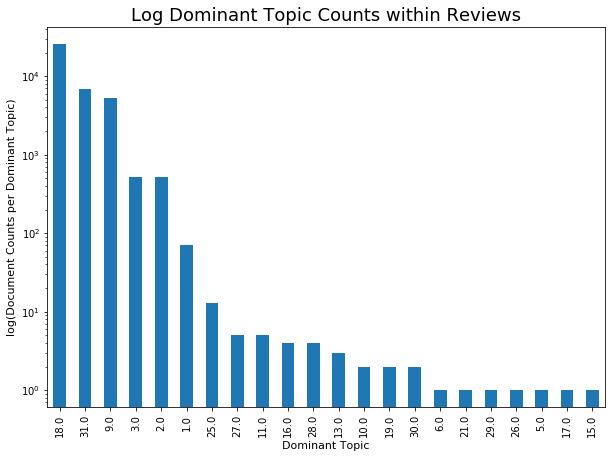

In [54]:
# # Number of Documents for Each Topic
# reviews_dominant_topic.groupby('name')['activity'].value_counts()
# topic_counts = df_dominant_topic['Dominant_Topic'].value_counts()
# ax = topic_counts.plot(kind='bar', logy=True,figsize=(10,7))
# ax.set_title("Log Dominant Topic Counts within Reviews", fontsize=18)
# ax.set_ylabel("log(Document Counts per Dominant Topic)", fontsize=11);
# ax.set_xlabel("Dominant Topic", fontsize=11);

### Find the most representative document for each topic

In [104]:
#Find the most representative document for each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.7452,"'refund',, 'nasti',, 'unabl',, 'newer',, 'dust...","[['spa',, 'facil',, 'realli',, 'nice',, 'larg'..."
1,2.0,0.8944,"'rude',, 'terribl',, 'mold',, 'overpr',, 'dont...","[['went',, 'la',, 'friend',, 'first',, 'time',..."
2,3.0,0.8686,"'stain',, 'carpet',, 'worn',, 'bug',, 'paint',...","[['return',, 'day',, 'busi',, 'trip',, 'stay',..."
3,5.0,0.3560,"'badli',, 'deal'], 'book'], ['decent',, 'isnt'...","[['decent',, 'hotel',, 'short',, 'stay']]"
4,6.0,0.4897,"'better'], 'receipt',, ['properti',, 'lousi',,...","[['disappoint',, 'room',, 'great',, 'servic',,..."


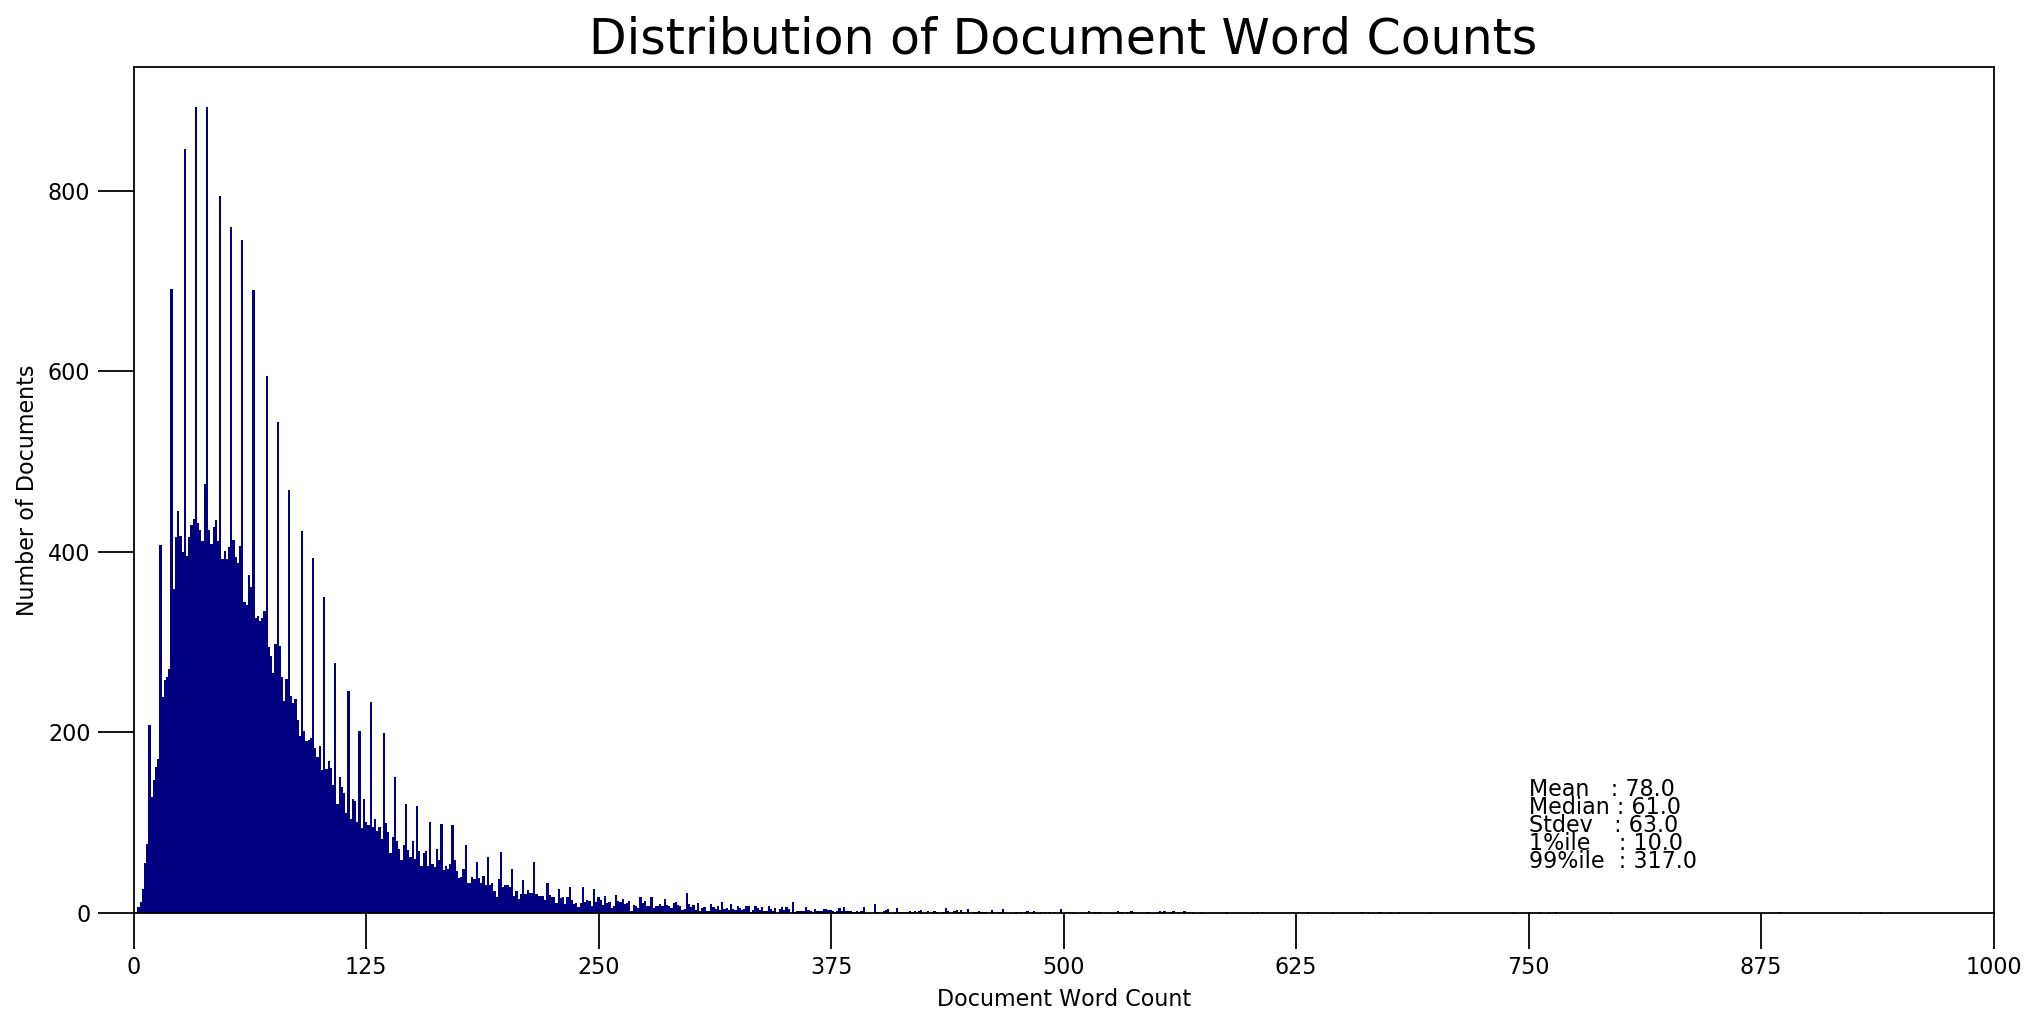

In [98]:
#Frequency Distribution of Word Counts in Documents
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(15,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 130, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  110, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  90, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  50, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()